In [ ]:
import sys
!{sys.executable} -m pip install opencv-python
!{sys.executable} -m pip install Pillow
!pip install scikit-image == 0.19.3
!{sys.executable} -m pip install -U matplotlib
!{sys.executable} -m pip install -U sklearn
!{sys.executable} -m pip install "napari[all]"

In [ ]:
import os
import cv2 # image processing library
from PIL import Image
from skimage import filters
from skimage.segmentation import (morphological_chan_vese,
                                  morphological_geodesic_active_contour,
                                  inverse_gaussian_gradient,
                                  checkerboard_level_set)
import imageio
import numpy as np # used for defining arrays
import numpy.random
import matplotlib.pyplot as plt # plt is a frequently used plotting function
import matplotlib.cm as cm
import copy # useful for copying arrays

from sklearn import datasets
from sklearn import preprocessing, svm, metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans

from scipy.io import loadmat # used to import .mat files
from PIL import Image # for importing images
import pdb # pdb is a helpful debugging library
from utils import imclearborder, imfill, bwareaopen, getContour

###  Goals
Working on image segmentation and reconstruction of lung CT images and a deep learning segmentation method for breast cancer to become familiar with how image processing can contribute to clinical diagnosis of disease, how specific properties of CT scans are used for image processing, and how to develop your own processing pipeline using image segmentation (via a K-means clustering algorithm). In addition, I am learning about ultrasound imaging techniques for breast cancer and using and evaluating a state of the art deep learning model for image segmentation!




In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
filepath =  "/content/drive/MyDrive/imageFiles.mat"

data = loadmat(filepath)
images = data['imageArray']

originalImages = copy.deepcopy(images)

Mounted at /content/drive


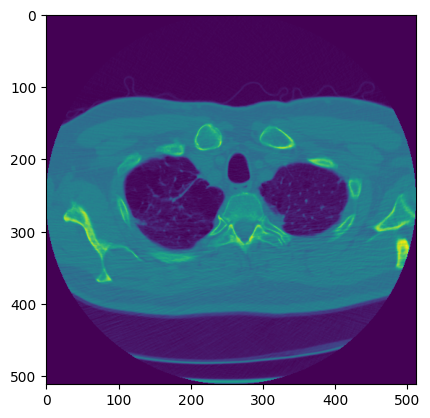

In [ ]:
plt.imshow(images[:,:,21])

(array([6.3788e+04, 6.4810e+03, 3.0940e+03, 9.2080e+03, 1.3217e+04,
        1.3999e+04, 1.1953e+04, 8.2620e+03, 5.2050e+03, 3.2750e+03,
        2.1740e+03, 1.5260e+03, 1.2610e+03, 1.0710e+03, 1.0560e+03,
        1.0810e+03, 9.0500e+02, 6.9100e+02, 5.6600e+02, 4.9200e+02,
        4.7500e+02, 4.3100e+02, 4.0300e+02, 4.1000e+02, 3.9900e+02,
        3.6500e+02, 3.4900e+02, 3.6500e+02, 3.4700e+02, 3.1800e+02,
        3.5500e+02, 3.3700e+02, 3.6600e+02, 3.3500e+02, 3.9700e+02,
        5.0600e+02, 1.4050e+03, 7.9870e+03, 1.4046e+04, 9.2470e+03,
        6.2870e+03, 5.2540e+03, 5.6900e+03, 8.8680e+03, 1.4472e+04,
        1.2354e+04, 4.6460e+03, 1.8800e+03, 1.1270e+03, 7.8500e+02,
        8.3500e+02, 8.1800e+02, 8.1200e+02, 7.6000e+02, 7.9500e+02,
        7.9400e+02, 6.9100e+02, 7.1900e+02, 6.2100e+02, 5.3600e+02,
        5.2700e+02, 4.4600e+02, 4.3700e+02, 4.3300e+02, 4.0000e+02,
        3.3700e+02, 3.2700e+02, 2.8000e+02, 2.1300e+02, 2.4100e+02,
        1.9800e+02, 1.6800e+02, 1.8300e+02, 1.75

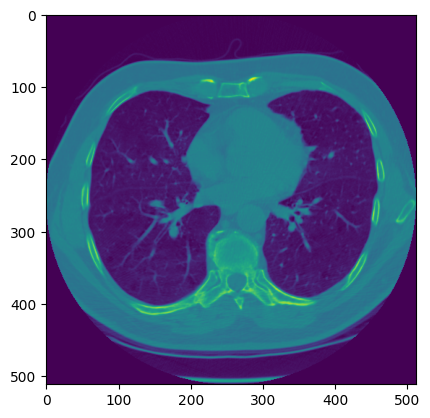

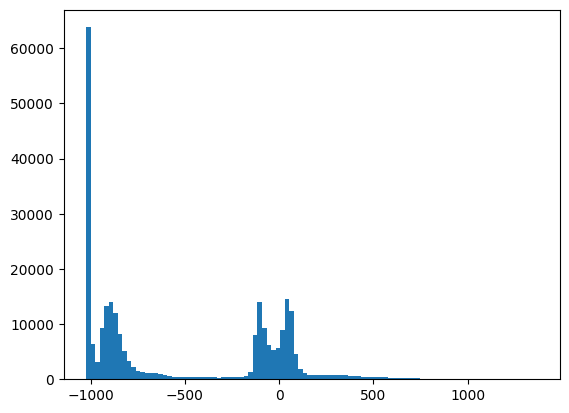

In [ ]:
# choosing image at index 80
plt.figure(1)
plt.imshow(images[:,:,81])

# making a histogram
plt.figure(2)
plt.hist(images[:,:,81].flatten(), 100)


### Performing K-means Clustering in CT Images

Segmenting each image in our stack into two different groups, a soft tissue/bone cluster and a air/lung cluster. Classify your each of the images of the image stack into two different groups (soft tissue/bone cluster and air/lung cluster), therefore assigning pixel to a 0 or 1 respectively.

Starting off by clustering a **single image** at **index 80**. First, we will convert from the original np array to a .jpeg, allowing  to create a Image object to access downstream functions.

---

<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)


<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]


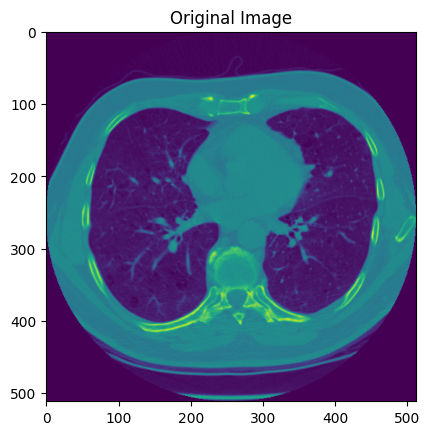

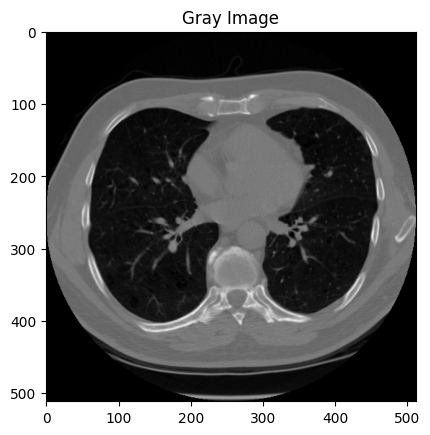

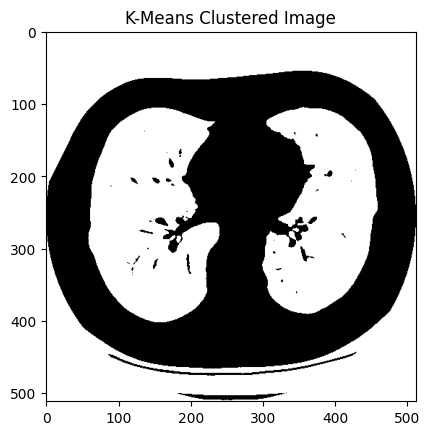

In [ ]:
# conversion from numpy array to .jpeg so I can convert to Image object, allowing use of the KMeans package
import matplotlib
from skimage.io import imsave, imread

def nparray2jpeg(index, images_stack):
  im = images_stack[:, :, index]
  imsave("name.png", im)
  imageOr = Image.open('name.png')
  return imageOr

# conversion to grayscale
def rgb2gray(imageOr):
  imageGray = imageOr.convert("L")
  return np.array(imageGray)

# Check that they match the centroids output 39.86045651, 105.9597251 for image index 80.
def kmeans_func(imageGray):
  print(type(imageGray))
  imgKflat = imageGray.reshape(imageGray.shape[0]*imageGray.shape[1], 1)
  kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(imgKflat)
  labels = kmeans.labels_ -1
  centroids = kmeans.cluster_centers_
  print(centroids)
  imgKflat = centroids[labels]
  return imgKflat

# Image Plotting
imageOr = nparray2jpeg(80, images)
plt.figure(0)
plt.title('Original Image');
plt.imshow(imageOr)

imageGray = rgb2gray(imageOr)
plt.figure(1)
plt.imshow(imageGray, cmap = cm.gray)
plt.title('Gray Image');

imgKflat = kmeans_func(imageGray)
imgK = imgKflat.reshape(imageGray.shape)
plt.figure(2)
plt.imshow(imgK, cmap = cm.gray)
plt.title('K-Means Clustered Image');




### Developing my own image-processing tool

 Write my own basic image processing function to convert images to black and white.

Text(0.5, 1.0, 'Black and White Image')

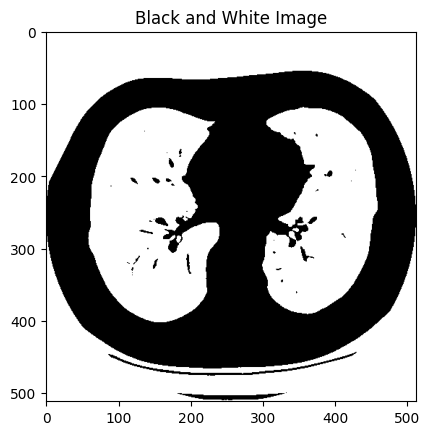

In [ ]:
def im2bw(image, threshold):
    image = cv2.threshold(image, threshold, 1, cv2.THRESH_BINARY)[1]
    return image

threshold = (np.max(imgKflat)+np.min(imgKflat))/2
imgPost = im2bw(imgK, threshold)
plt.figure(2)
plt.imshow(imgPost, cmap = cm.gray)
plt.title('Black and White Image')


### Cleaning up image masks using openCV tools

**imclearborder** - removes any small objects coinciding with the border of the image. Takes an input image array and an object area (in pixels) and returns a cleaned output image.

outputImage = imclearborder(inputImage, objectSize = 500)

**imfill** - fills in the background of an image with a uniform constant (default is black, pixel value = 0). Takes an input image array, an optional fill value, and returns a filled output image.

outputImage = imfill(inputImage, fillValue = 0)

**bwareaopen** - fills in any open "holes" smaller than a specified area (default is 500 pixels) with a constant pixel value (default is black, pixel value = 0). Takes an input image array, an optional area and fill value, and returns a cleaned output image.

outputImage = bwareaopen(inputImage, objectSize = 500, fillValue = 0)

<img src="imgs/Kmeansclean.png"  width="600"/>

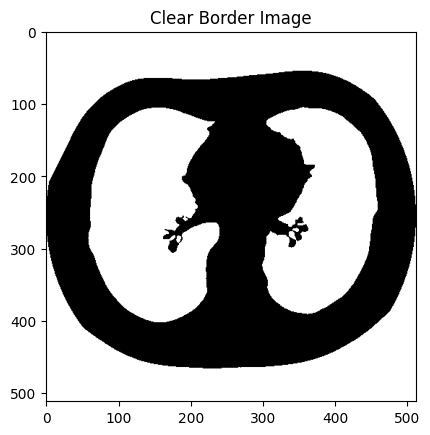

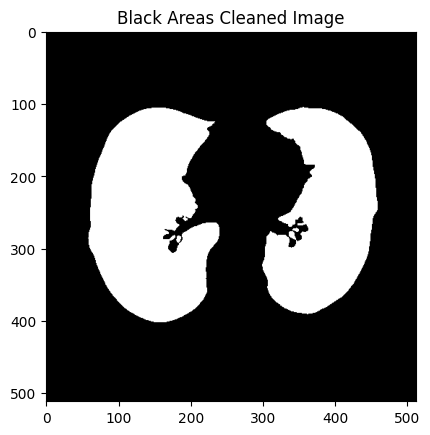

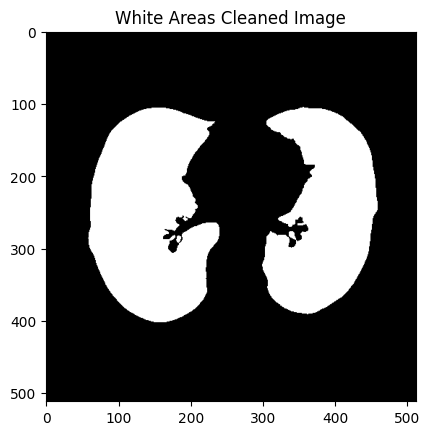

In [ ]:
imgPost = imclearborder(imgPost, 500)
plt.figure(1)
plt.imshow(imgPost,cmap=cm.gray)
plt.title('Clear Border Image');

imgPost = imfill(imgPost, 0)
plt.figure(2)
plt.imshow(imgPost,cmap=cm.gray)
plt.title('Black Areas Cleaned Image');

imgPost = bwareaopen(imgPost, 500, 0)
plt.figure(3)
plt.imshow(imgPost,cmap=cm.gray)
plt.title('White Areas Cleaned Image');


### Applying KMeans to my Stack of Images

<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)


<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]


<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)
<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)


<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]


<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)


<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]


<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)


<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]


<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)


<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]


<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)


<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]


<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)


<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]


<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)


<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]
<class 'numpy.ndarray'>


<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)


[[ 10.43983273]
 [118.26872179]]
<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]


<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)
<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)


<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]


<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)


<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]


<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)


<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]


<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)


<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]


<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)


<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]


<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)


<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]


<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)


<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]


<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)


<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]


<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)


<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]


<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)


<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]


<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)


<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]
<class 'numpy.ndarray'>


<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)
<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)


[[ 10.43983273]
 [118.26872179]]
<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]


<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)
<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)


<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]
<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]


<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)
<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)


<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]
<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]


<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)
<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)


<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]
<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]


<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)
<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)


<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]
<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]


<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)
<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)


<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]
<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]


<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)
<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)


<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]
<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]


<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)
<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)


<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]
<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]


<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)
<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)


<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]
<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]


<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)
<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)


<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]
<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]


<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)
<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)


<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]
<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]


<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)
<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)


<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]
<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]


<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)
<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)


<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]
<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]


<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)
<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)


<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]
<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]


<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)
<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)


<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]
<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]


<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)


<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]
<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]


<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)
<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)
<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)


<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]
<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]


<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)
<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)


<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]
<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]


<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)
<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)


<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]
<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]


<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)


<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]
<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]


<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)
<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)
<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)


<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]
<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]


<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)
<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)


<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]
<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]


<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)
<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)


<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]
<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]


<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)
<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)


<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]
<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]


<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)
<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)


<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]
<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]


<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)


<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]
<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]


<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)
<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)


<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]
<class 'numpy.ndarray'>


<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)
<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)


[[ 10.43983273]
 [118.26872179]]
<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]


<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)
<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)


<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]
<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]


<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)
<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)


<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]
<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]


<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)
<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)


<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]
<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]


<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)
<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)


<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]
<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]


<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)
<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)


<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]
<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]


<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)


<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]
<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]


<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)
<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)


<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]
<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]


<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)
<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)
<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)


<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]
<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]


<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)
<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)


<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]
<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]


<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)


<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]


<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)


<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]


<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)


<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]


<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)


<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]


<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)


<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]


<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)


<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]


<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)


<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]


<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)


<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]


<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)


<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]


<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)


<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]


<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)


<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]


<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)


<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]


<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)


<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]


<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)


<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]


<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)


<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]


<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)


<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]


<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)


<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]


<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)


<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]
<class 'numpy.ndarray'>


<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)
<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)


[[ 10.43983273]
 [118.26872179]]
<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]


<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)
<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)


<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]
<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]


<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)
<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)


<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]
<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]


<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)
<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)


<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]
<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]


<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)
<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)


<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]
<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]


<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)
<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)


<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]
<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]


<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)
<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)


<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]
<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]


<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)
<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)


<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]
<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]


<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)
<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)


<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]
<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]


<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)
<ipython-input-6-168871ac8dd5>:7: UserWarning: name.png is a low contrast image
  imsave("name.png", im)


<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]
<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]
<class 'numpy.ndarray'>
[[ 10.43983273]
 [118.26872179]]


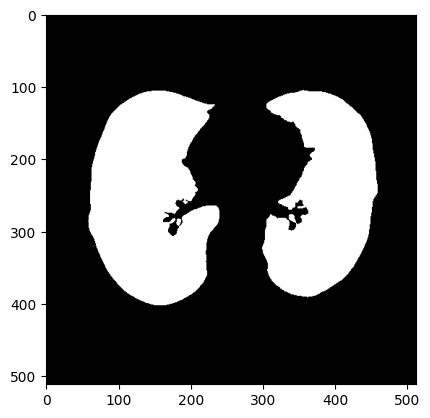

In [ ]:
def kmeans_stack(images):
  cluster = np.zeros(images.shape)
  for index in range(images.shape[2]):
    Jpeg = nparray2jpeg(index, images)
    grayIMG = rgb2gray(Jpeg)
    imgKmeans = kmeans_func(imageGray)
    imgKmeans = imgKmeans.reshape(imageGray.shape)
    threshold = (np.max(imgKmeans)+np.min(imgKmeans))/2
    imgPost = im2bw(imgKmeans, threshold)
    imgPost1 = imclearborder(imgPost, 500)
    imgPost2 = imfill(imgPost1, 0)
    imgPost3 = bwareaopen(imgPost2, 500, 0)
    cluster[:,:, index] = imgPost3
  return cluster

cluster_mask = kmeans_stack(images)

## Picking an image at index 80 for debugging purposes
plt.imshow(cluster_mask[:, :, 80], cmap= cm.gray)



### Applying image masks to original images

apply my masks to original images so that we extract just the lung portion of the image.

<img src="imgs/maskedlung.png"  width="200"/>



In [ ]:
maskedImages = images*cluster_mask




```
# This is formatted as code
```



### Saving masked images

export my stack of cleaned masks and masked images to the "outputImages/masks" and "outputImages/lung" folder. Naming each image mask0-maskn or lung0-lungn and save your image as a .tiff file using the [imageio.imwrite](https://imageio.readthedocs.io/en/stable/userapi.html) function.

In [ ]:
for i in range(maskedImages.shape[2]):
    imageio.imwrite("/content/drive/MyDrive/outputImages/masks/mask"+str(i)+ ".tiff", cluster_mask[:,:,i].astype( 'uint8'))
    imageio.imwrite("/content/drive/MyDrive/outputImages/lung/lung"+str(i)+ ".tiff", cluster_mask[:,:,i].astype( 'uint8'))


In [ ]:
from skimage import data
import napari

viewer = napari.view_image(data.astronaut(), rgb=True)

Cannot move to target thread (0x4293ad0)

Cannot move to target thread (0x4293ad0)


Available platform plugins are: xcb, eglfs, linuxfb, minimal, minimalegl, offscreen, vnc, wayland-egl, wayland, wayland-xcomposite-egl, wayland-xcomposite-glx, webgl.


Available platform plugins are: xcb, eglfs, linuxfb, minimal, minimalegl, offscreen, vnc, wayland-egl, wayland, wayland-xcomposite-egl, wayland-xcomposite-glx, webgl.



# Deep Learning For Image Segmentation

Background

Breast cancer: The U.S. Preventive Services Task Force recently published a statement that women should start receiving mammograms at age 40 instead of 50 (Bever, L. The Washington Post, 2023). Mammograms are a commonly used diagnostic imaging test to detect breast cancer early, and data has shown mammography screening can reduce breast cancer-associated deaths. If a suspicious lesion is detected on mammography, ultrasound is commonly used as a follow up diagnostic to further visualize the lesion. Ultrasound can also in some instances detect early-stage breast cancers that are not detected by mammography.

Dataset

This breast ultrasound dataset is categorized into three classes  :  normal, benign, and malignant images. The data collected at baseline includes breast ultrasound images among women in ages between 25 and 75 years old. This data was collected in 2018. Labels were produced by physicians specializing in oncology. The number of patients is 600 female patients. The dataset consists of 780 images with an average image size of 500*500 pixels. The images are in PNG format.

**Approach**:
Segmentation --converting an image into a collection of regions of pixels that are represented by a mask or a labeled image -- is a task deep learning methods have proven to be exceptional at. To read more about auto-segmentation look no further: https://www.analyticsvidhya.com/blog/2019/04/introduction-image-segmentation-techniques-python/

AttentionUNet/UNet is the best know model for Multi-Class Segmentation. It works by encoding the image into a lower dimensional embedding. The embeddings will have more dense information that the model can use to reconstruct the image with masks for objects.

All the images are of 500 X 500 pixels, but we will be resizing the Image to 256 X 256 pixels.
Model Architecture

The Model will consist of a Encoder Block, Decoder Block and a Attention Gate.

In [ ]:
from IPython.display import clear_output
!pip install tf_explain
!pip install keras
clear_output()

In [ ]:
# common
import os
import keras
import numpy as np
import pandas as pd
from glob import glob
import tensorflow as tf
import tensorflow.image as tfi

# Data
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# Data Viz
import matplotlib.pyplot as plt

# Model
from keras.models import Model
from keras.layers import Layer
from keras.layers import Conv2D
from keras.layers import Dropout
from keras.layers import UpSampling2D
from keras.layers import concatenate
from keras.layers import Add
from keras.layers import Multiply
from keras.layers import Input
from keras.layers import MaxPool2D
from keras.layers import BatchNormalization

# Callbacks
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from tf_explain.core.grad_cam import GradCAM

# Metrics
from keras.metrics import MeanIoU

 load_images

In [ ]:
def load_image(image, SIZE):
    return np.round(tfi.resize(img_to_array(load_img(image))/255.,(SIZE, SIZE)),4)

def load_images(image_paths, SIZE, mask=False):
    if mask:
      images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 1))
    else:
      images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 3))
    #your code here
    for index, image_path in enumerate(image_paths):
      loaded_image = load_image(image_path, SIZE)
      if mask:
        images[index] = loaded_image[:,:,:1]
      else:
        images[index] = loaded_image

    #end your code
    return images

In [ ]:
def show_image(image, title=None, cmap=None, alpha=1):
    plt.imshow(image, cmap=cmap, alpha=alpha)
    if title is not None:
        plt.title(title)
    plt.axis('off')

def show_mask(image, mask, cmap=None, alpha=0.4):
    plt.imshow(image)
    plt.imshow(tf.squeeze(mask), cmap=cmap, alpha=alpha)
    plt.axis('off')

## Load in Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
SIZE = 256

In [ ]:
root_path = "/content/drive/MyDrive/Dataset_BUSI_with_GT/" #insert path to Dataset_BUSI_with_GT
classes = sorted(os.listdir(root_path))
classes

['benign', 'malignant', 'normal']

In [ ]:
single_mask_paths = sorted([sorted(glob(root_path + name + "/*mask.png")) for name in classes])
double_mask_paths = sorted([sorted(glob(root_path + name + "/*mask_1.png")) for name in classes])

In [ ]:
image_paths = []
mask_paths = []
for class_path in single_mask_paths:
    for path in class_path:
        img_path = path.replace('_mask','')
        image_paths.append(img_path)
        mask_paths.append(path)

In [ ]:
images = load_images(image_paths, SIZE)
masks = load_images(mask_paths, SIZE, mask=True)
#add assert for length of paths
assert len(masks) == len(images)


In [ ]:
sns.heatmap(images[1][:,:,0])

NameError: ignored

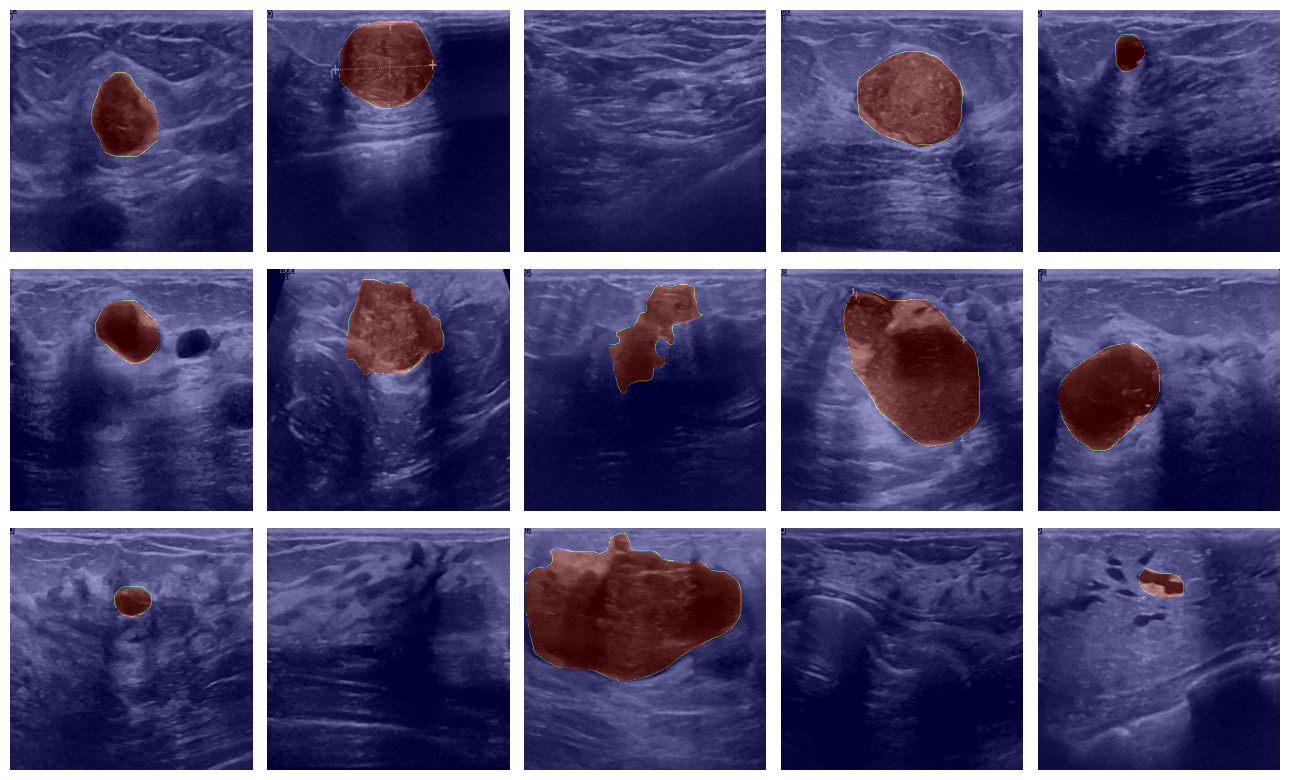

In [ ]:
plt.figure(figsize=(13,8))
for i in range(15):
    plt.subplot(3,5,i+1)
    id = np.random.randint(len(images))
    show_mask(images[id], masks[id], cmap='jet')
plt.tight_layout()
plt.show()

## Convolutional Encoder-Decoder

The model I will use is a more complex version of a Convolutional encoder-decoder. Convolutional encoders can take an image and compress it down to a lower dimensional embedding vector (the arrow in the center of the diagram). It is assumed that the model has learned important features in the image and represents those features in this latent space (analogous to principle compontent reduction!). From this embedding the model can decode the information and reconstruct the image but with masks! These masks will have different pixel values to represent different classes of objects in an image. In the example of figure this includes cars, road, etc.

![Screen Shot 2022-04-19 at 5.41.25 PM.png](https://assets-global.website-files.com/5d7b77b063a9066d83e1209c/60e4224cd4055dbcc47df218_convolutional-encoder-decoder.png)

### Attention based u-net explanation

Our specific model is a attention based u-net. A u-net is similar to the standard convolutional encoder-decoder model but includes a method that uses spatial information from the images in the encoder portion for the decoding portion of the model.

The attention u-net also has attention components built into it. Attention is a popular deep learning method that is used to train models like Chat-GPT! Attention is applied where spatial information is from the encoder is being applied to the decoder. Attention allows the model to learn what spatial information to put a lot of weights on (or pay attnetion to) in order to predict masks as the embedding is being decoded.

To gain a better intution about the attention mechanism I will be implementing a toy example.



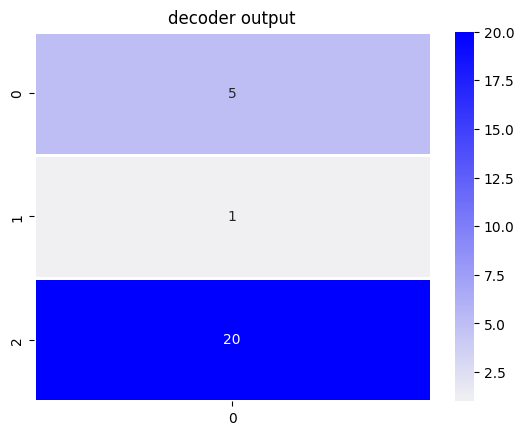

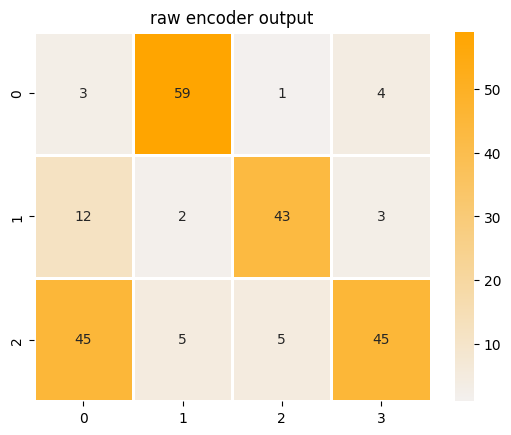

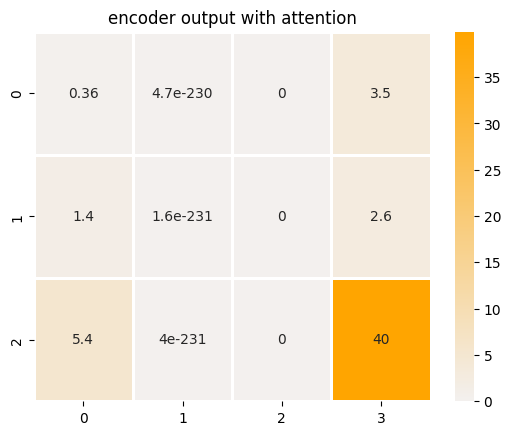

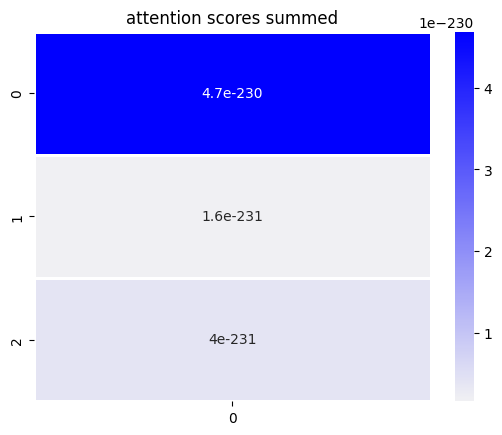

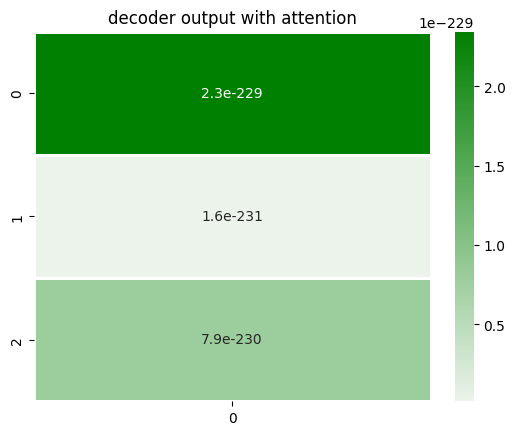

In [ ]:
import seaborn as sns
def dot_attention_score(decoder_output, encoder_output):
 return np.matmul(np.transpose(decoder_output), encoder_output)

def softmax(x):
 x = np.array(x, dtype=np.float128)
 e_x = np.exp(x)
 return e_x / e_x.sum(axis=0)


def apply_attention_scores(attention_weights, encoder_output):
 applied_attention = attention_weights* encoder_output
 return applied_attention

def calculate_attention_vector(applied_attention):

  attention_vector = applied_attention[:,1]
  return attention_vector

def concat_attnetion_decoder(attention_vector, decoder_output):
  decoder_output_with_attention = attention_vector*decoder_output
  return decoder_output_with_attention

decoder_output = [5,1,20]
encoder_output = np.transpose([[3,12,45], [59,2,5], [1,43,5], [4,3,45.3]])

#ploting heatmap of inputs
plt.title('decoder output')
sns.heatmap(np.transpose(np.matrix(decoder_output)), annot=True, cmap=sns.light_palette('Blue', as_cmap=True), linewidths=1)
plt.show()

plt.title('raw encoder output')
sns.heatmap(encoder_output, annot=True, cmap=sns.light_palette('orange', as_cmap=True), linewidths=1)
plt.show()

#perform attention vector calculation and apply attention to decoder output
attention_weights_raw = dot_attention_score(decoder_output, encoder_output)

attention_weights = softmax(attention_weights_raw)

applied_attention = apply_attention_scores(attention_weights, encoder_output)

attention_vector = calculate_attention_vector(applied_attention)

decoder_output_with_attention = concat_attnetion_decoder(attention_vector, decoder_output)

#plot attention scoring and final vector output
plt.title('encoder output with attention')
sns.heatmap(applied_attention, annot=True, cmap=sns.light_palette('orange', as_cmap=True), linewidths=1)
plt.show()

plt.title('attention scores summed')
sns.heatmap(np.transpose(np.matrix(attention_vector)), annot=True, cmap=sns.light_palette('Blue', as_cmap=True), linewidths=1)
plt.show()

plt.title('decoder output with attention')
sns.heatmap(np.transpose(np.matrix(decoder_output_with_attention)), annot=True, cmap=sns.light_palette('Green', as_cmap=True), linewidths=1)
plt.show()



##Model

**Encoder**

In [ ]:
class EncoderBlock(Layer):

    def __init__(self, filters, rate, pooling=True, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)

        self.filters = filters
        self.rate = rate
        self.pooling = pooling

        self.c1 = Conv2D(filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
        self.drop = Dropout(rate)
        self.c2 = Conv2D(filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
        self.pool = MaxPool2D()

    def call(self, X):
        x = self.c1(X)
        x = self.drop(x)
        x = self.c2(x)
        if self.pooling:
            y = self.pool(x)
            return y, x
        else:
            return x

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            'rate':self.rate,
            'pooling':self.pooling
        }

**Decoder**

In [ ]:
class DecoderBlock(Layer):

    def __init__(self, filters, rate, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)

        self.filters = filters
        self.rate = rate

        self.up = UpSampling2D()
        self.net = EncoderBlock(filters, rate, pooling=False)

    def call(self, X):
        X, skip_X = X
        x = self.up(X)
        c_ = concatenate([x, skip_X])
        x = self.net(c_)
        return x

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            'rate':self.rate,
        }

**Attention Gate**

In [ ]:
class AttentionGate(Layer):

    def __init__(self, filters, bn, **kwargs):
        super(AttentionGate, self).__init__(**kwargs)

        self.filters = filters
        self.bn = bn

        self.normal = Conv2D(filters, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')
        self.down = Conv2D(filters, kernel_size=3, strides=2, padding='same', activation='relu', kernel_initializer='he_normal')
        self.learn = Conv2D(1, kernel_size=1, padding='same', activation='sigmoid')
        self.resample = UpSampling2D()
        self.BN = BatchNormalization()

    def call(self, X):
        X, skip_X = X

        x = self.normal(X)
        skip = self.down(skip_X)
        x = Add()([x, skip])
        x = self.learn(x)
        x = self.resample(x)
        f = Multiply()([x, skip_X])
        if self.bn:
            return self.BN(f)
        else:
            return f
        # return f

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            "bn":self.bn
        }

**Callback**

In [ ]:
class ShowProgress(Callback):
    def on_epoch_end(self, epochs, logs=None):
        id = np.random.randint(200)
        exp = GradCAM()
        image = images[id]
        mask = masks[id]
        pred_mask = self.model.predict(image[np.newaxis,...])
        cam = exp.explain(
            validation_data=(image[np.newaxis,...], mask),
            class_index=1,
            layer_name='Attention4',
            model=self.model
        )

        plt.figure(figsize=(10,5))

        plt.subplot(1,3,1)
        plt.title("Original Mask")
        show_mask(image, mask, cmap='copper')

        plt.subplot(1,3,2)
        plt.title("Predicted Mask")
        show_mask(image, pred_mask, cmap='copper')

        plt.subplot(1,3,3)
        show_image(cam,title="GradCAM")

        plt.tight_layout()
        plt.show()

**Attention UNet**

In [ ]:
# Inputs
input_layer = Input(shape=images.shape[-3:])

# Encoder
p1, c1 = EncoderBlock(32,0.1, name="Encoder1")(input_layer)
p2, c2 = EncoderBlock(64,0.1, name="Encoder2")(p1)
p3, c3 = EncoderBlock(128,0.2, name="Encoder3")(p2)
p4, c4 = EncoderBlock(256,0.2, name="Encoder4")(p3)

# Encoding
encoding = EncoderBlock(512,0.3, pooling=False, name="Encoding")(p4)

# Attention + Decoder

a1 = AttentionGate(256, bn=True, name="Attention1")([encoding, c4])
d1 = DecoderBlock(256,0.2, name="Decoder1")([encoding, a1])

a2 = AttentionGate(128, bn=True, name="Attention2")([d1, c3])
d2 = DecoderBlock(128,0.2, name="Decoder2")([d1, a2])

a3 = AttentionGate(64, bn=True, name="Attention3")([d2, c2])
d3 = DecoderBlock(64,0.1, name="Decoder3")([d2, a3])


a4 = AttentionGate(32, bn=True, name="Attention4")([d3, c1])
d4 = DecoderBlock(32,0.1, name="Decoder4")([d3, a4])

# Output
output_layer = Conv2D(1, kernel_size=1, activation='sigmoid', padding='same')(d4)

# Model
model = Model(
    inputs=[input_layer],
    outputs=[output_layer]
)

# Compile
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy', MeanIoU(num_classes=2, name='IoU')]
)

# Callbacks
cb = [
    # EarlyStopping(patience=3, restore_best_weight=True), # With Segmentation I trust on eyes rather than on metrics
    ModelCheckpoint("AttentionCustomUNet.h5", save_best_only=True),
    ShowProgress()
]

**Callback**

In [ ]:
class ShowProgress(Callback):
    def on_epoch_end(self, epochs, logs=None):
        id = np.random.randint(200)
        exp = GradCAM()
        image = images[id]
        mask = masks[id]
        pred_mask = self.model.predict(image[np.newaxis,...])
        cam = exp.explain(
            validation_data=(image[np.newaxis,...], mask),
            class_index=1,
            layer_name='Attention4',
            model=self.model
        )

        plt.figure(figsize=(10,5))

        plt.subplot(1,3,1)
        plt.title("Original Mask")
        show_mask(image, mask, cmap='copper')

        plt.subplot(1,3,2)
        plt.title("Predicted Mask")
        show_mask(image, pred_mask, cmap='copper')

        plt.subplot(1,3,3)
        show_image(cam,title="GradCAM")

        plt.tight_layout()
        plt.show()

MUST ACTIVATE YOUR GPU IN COLAB

## Training

In [ ]:
# Config Training
BATCH_SIZE = 8
SPE = SIZE/BATCH_SIZE

# Training
results = model.fit(
    images, masks,
    validation_split= .2,
    epochs=15,
    steps_per_epoch= SPE,
    batch_size= BATCH_SIZE ,
    callbacks=cb
)

## Evaluation plots

In [ ]:
loss, accuracy, iou, val_loss, val_accuracy, val_iou = results.history.values()

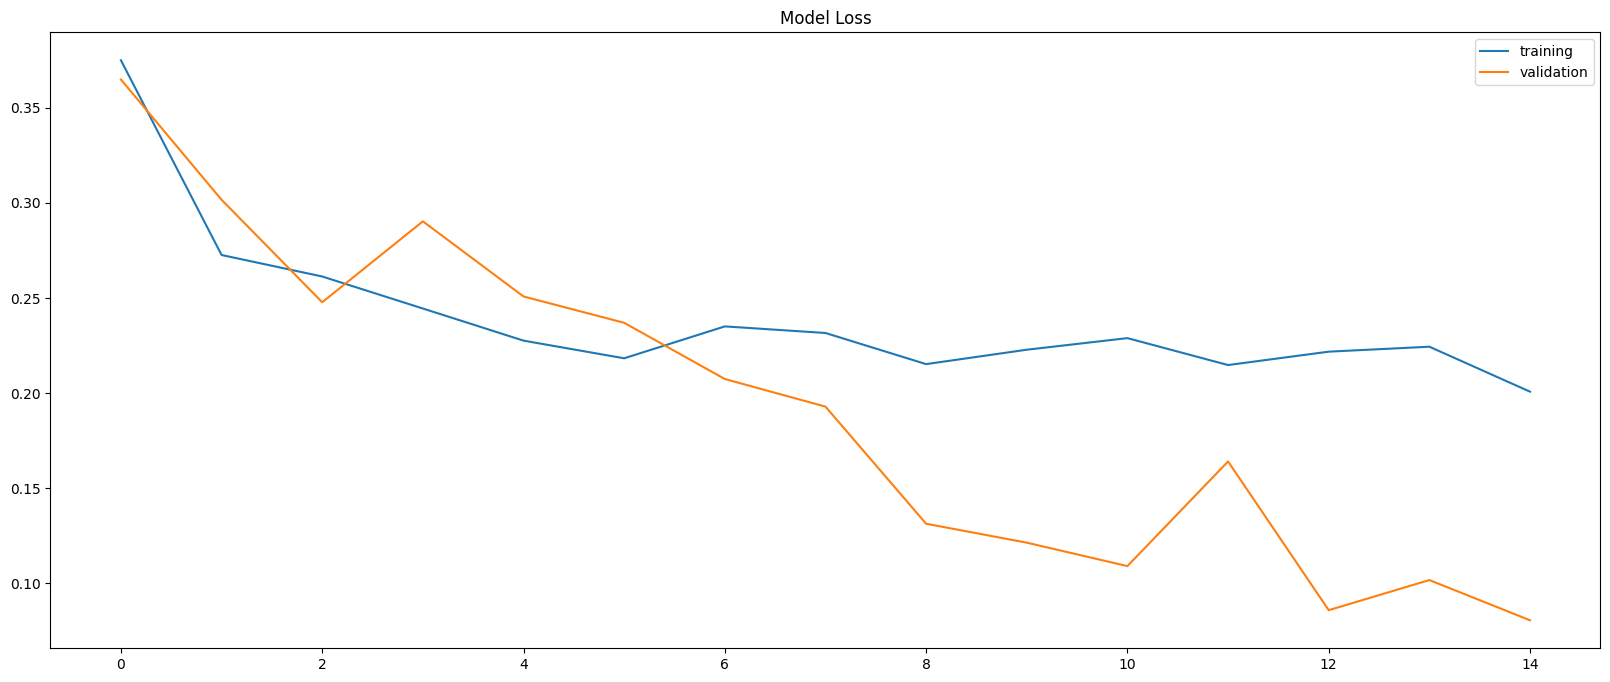

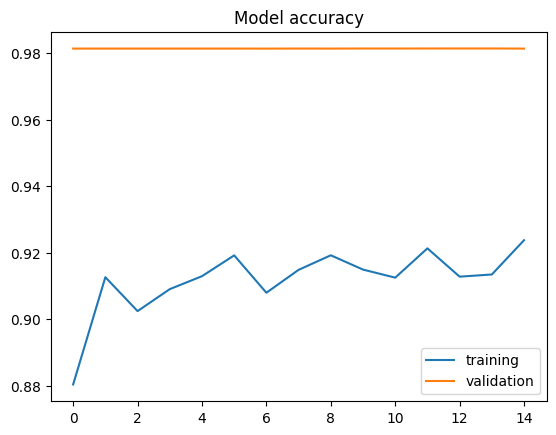

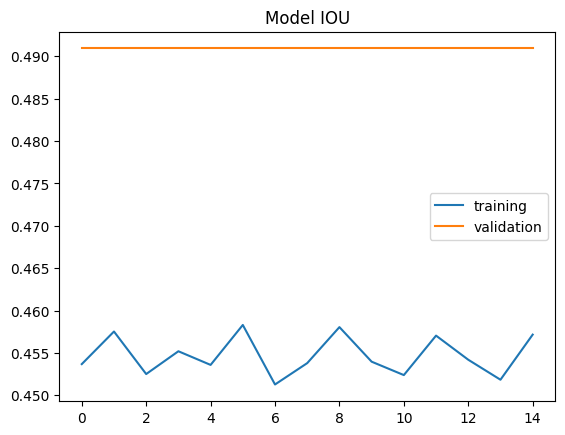

In [ ]:
plt.figure(figsize=(20,8))

#plot model loss
plt.figure(1)
plt.title("Model Loss")
plt.plot(loss)
plt.plot(val_loss)
plt.legend(["training", "validation"])
#plot model accuracy
plt.figure(2)
plt.title("Model accuracy")
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.legend(["training", "validation"])
#plot IOU
plt.figure(3)
plt.title("Model IOU")
plt.plot(iou)
plt.plot(val_iou)
plt.legend(["training", "validation"])
plt.show()

## writting own IOU function

Jaccard Index -- or the intersection Over Union (IOU) -- is a metric that is useful for segmentation models. The IOU is preferred over other metrics, such as accuracy, in segmentation tasks even though you are performing a class prediction. Accuracy is heavily biased by class imbalances. For example, if a ground truth image contains 90% background pixels, a suggested segmentation that labels all pixels as “background” will have a 90% accuracy. IOU on the other hand is calculated by taking the union of the dividing the overlap between the predicted and ground truth annotation by the union of these.

In [ ]:
def calc_IOU(predicted, ground_truth):
  overlap = predicted * ground_truth
  union = (predicted + ground_truth)
  union = (union>=1).astype('float')
  IOU = np.sum(overlap)/np.sum(union)
  return IOU

1/1 [==============================] - 0s 45ms/step
0.023536895674300253


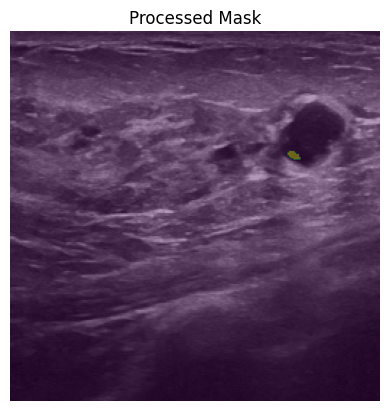

In [ ]:
id = 20
image = images[id]
mask = masks[id]
pred_mask = model.predict(image[np.newaxis,...])

plt.title("Original Mask")
show_mask(image, mask)

plt.title("Predicted Mask")
show_mask(image, pred_mask)

pred_mask = (pred_mask>0.5).astype('float')
plt.title("Processed Mask")
show_mask(image, pred_mask)

#add assert for sanity check
print(str(calc_IOU(pred_mask, mask)))

In [ ]:
#check
assert(0.9894168019114828 == calc_IOU(pred_mask, mask) )

<ipython-input-131-4c0db0b0cd37>:16: RuntimeWarning: invalid value encountered in true_divide
  IOU = overlap/union


ValueError: ignored